In [1]:
import pandas as pd
from pandas import DataFrame
df = pd.read_csv('a391d853147b-NASA_DataSets_Scrub.tsv', sep='\t')
import copy
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
import math
import numpy as np
from torch.autograd import Variable, Function
import pickle
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from gensim.models.coherencemodel import CoherenceModel
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
n_top_words = 20
nltk.download('wordnet')

if torch.cuda.device_count() == 0:
    device = 'cpu'
else:
    device = 'cuda'


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
stemmer = SnowballStemmer('english')
# def lemmatize_stemming(text):
#     return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def lemmatize(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')


def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(set(token))>1:
            result.append(lemmatize(token))
    return result

In [0]:
df = df.dropna()
df['desc_title'] = df['description'] + '\n' + df['title']
df['tokenized_desc'] = df['description'].map(preprocess)
df['tokenized_title'] = df['title'].map(preprocess)
df['tokenized_desc_title'] = df['tokenized_desc'] + df['tokenized_title']
df = df[df['tokenized_desc_title'].str.len()!=0]

In [0]:
dictionary = gensim.corpora.Dictionary(df['tokenized_desc_title'])

In [0]:
bow_corpus = [dictionary.doc2bow(doc) for doc in df['tokenized_desc_title']]

from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]


In [0]:
def compute_coherence_LDA(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=2, workers=2, dtype=np.float64)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v', topn = n_top_words)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

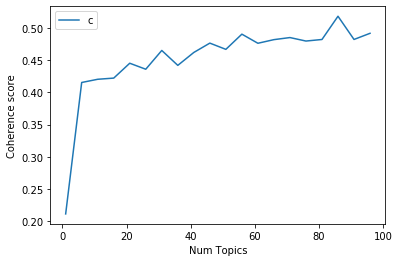

In [7]:
model_list, coherence_values = compute_coherence_LDA(dictionary=dictionary, corpus=corpus_tfidf, texts=df['tokenized_desc_title'], start=1, limit=100, step=5)
# Show graph
import matplotlib.pyplot as plt
limit=100; start=1; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [0]:
# 6 topics is maximum

In [0]:
class ProdLDA(nn.Module):

    def __init__(self, net_arch):
        super(ProdLDA, self).__init__()
        ac = net_arch
        self.net_arch = net_arch
        # encoder
        self.en1_fc     = nn.Linear(ac['num_input'], ac['en1_units'])             # 1995 -> 100
        self.en2_fc     = nn.Linear(ac['en1_units'], ac['en2_units'])             # 100  -> 100
        self.en2_drop   = nn.Dropout(0.2)
        self.mean_fc    = nn.Linear(ac['en2_units'], ac['num_topic'])             # 100  -> 50
        self.mean_bn    = nn.BatchNorm1d(ac['num_topic'])                      # bn for mean
        self.logvar_fc  = nn.Linear(ac['en2_units'], ac['num_topic'])             # 100  -> 50
        self.logvar_bn  = nn.BatchNorm1d(ac['num_topic'])                      # bn for logvar
        self.softplus = nn.Softplus()
        # z
        self.p_drop     = nn.Dropout(0.2)
        # decoder
        self.decoder    = nn.Linear(ac['num_topic'], ac['num_input'])             # 50   -> 1995
        self.decoder_bn = nn.BatchNorm1d(ac['num_input'])                      # bn for decoder
        # prior mean and variance as constant buffers
        prior_mean   = torch.zeros((1, ac['num_topic']), requires_grad=False)
        prior_var    = torch.zeros((1, ac['num_topic']), requires_grad=False).fill_(ac['variance'])
        prior_logvar = prior_var.log()
        self.register_buffer('prior_mean',    prior_mean)
        self.register_buffer('prior_var',     prior_var)
        self.register_buffer('prior_logvar',  prior_logvar)

    def forward(self, model_input, compute_loss=False):
        # compute posterior
        en1 = self.softplus(self.en1_fc(model_input))                            # en1_fc   output
        en2 = self.softplus(self.en2_fc(en1))                              # encoder2 output
        en2 = self.en2_drop(en2)
        posterior_mean   = self.mean_bn(self.mean_fc(en2))          # posterior mean
        posterior_logvar = self.logvar_bn(self.logvar_fc(en2))          # posterior log variance
        posterior_var    = posterior_logvar.exp()
        # take sample
        eps = Variable(model_input.data.new().resize_as_(posterior_mean.data).normal_(), requires_grad=False) # noise
        z = posterior_mean + posterior_var.sqrt() * eps                 # reparameterization
        p = F.softmax(z, -1)                                                # mixture probability
        p = self.p_drop(p)
        # do reconstruction
        recon = F.softmax(self.decoder_bn(self.decoder(p)),-1)             # reconstructed distribution over vocabulary

        if compute_loss:
            return recon, self.loss(model_input, recon, posterior_mean, posterior_logvar, posterior_var)
        else:
            return recon

    def loss(self, model_input, recon, posterior_mean, posterior_logvar, posterior_var):
        # NL
        NL  = -(model_input * (recon+1e-10).log()).sum(-1)
        # KLD, see Section 3.3 of Akash Srivastava and Charles Sutton, 2017, 
        # https://arxiv.org/pdf/1703.01488.pdf
        prior_mean   = self.prior_mean.expand_as(posterior_mean)
        prior_var    = self.prior_var.expand_as(posterior_mean)
        prior_logvar = self.prior_logvar.expand_as(posterior_mean)
        var_division    = posterior_var  / prior_var
        diff            = posterior_mean - prior_mean
        diff_term       = diff * diff / prior_var
        logvar_division = prior_logvar - posterior_logvar
        # put KLD together
        KLD = 0.5 * ( (var_division + diff_term + logvar_division).sum(-1) - self.net_arch['num_topic'] )
        # loss
        loss = (NL + KLD)
        # in traiming mode, return averaged loss. In testing mode, return individual loss
        return loss.sum()

In [0]:
def train(optimizer, model, data_loader, args, num_epoch = 20):
    for epoch in range(num_epoch):
        loss_epoch = 0.0
        all_indices = 0
        model.train()                   # switch to training mode
        for batch in data_loader:
            optimizer.zero_grad()
            batch = batch.float().to(device)
            recon, loss = model(batch, compute_loss=True)
            # optimize
            loss.backward()             # backprop
            optimizer.step()            # update parameters
            # report
            loss_epoch += loss.item()    # add loss to loss_epoch
            all_indices += batch.shape[0]
        if epoch % 5 == 0:
            print('Epoch {}, loss={}'.format(epoch, loss_epoch / all_indices))

class TopicModel(Dataset):

    def __init__(self, corpus = bow_corpus, len_dict = len(dictionary)):
        self.corpus = corpus
        self.len_dict = len_dict

    def __len__(self):
        return len(self.corpus)

    def __getitem__(self, idx):
        sample = np.zeros(self.len_dict)
        index, value = zip(*self.corpus[idx])
        sample[list(index)] = list(value)
        return sample       

In [0]:
args = {'num_input':len(dictionary),'en1_units': 100, 'en2_units': 100, 'num_topic': 6, 'batch_size': 128, 'init_mult': 1, 'variance': 0.995}

dataset = TopicModel()
loader = torch.utils.data.DataLoader(dataset = dataset, 
                                              batch_size = args['batch_size'],
                                              shuffle = True)

def compute_coherence_prodLDA(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    best_coherence = 0
    for num_topics in range(start, limit, step):
        args['num_topic'] = num_topics
        model = ProdLDA(args).to(device)
        optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad == True], 0.002, betas=(0.99, 0.999))

        train(optimizer, model, loader, num_epoch = 50, args = args)
        emb = model.decoder.weight.data.cpu().numpy().T
        feature_names = list(zip(*sorted(dictionary.items(), key=lambda x:x[0])))[1]

        topics = [[feature_names[j] for j in emb[i].argsort()[:-n_top_words - 1:-1]] for i in range(emb.shape[0])]
        coherencemodel = CoherenceModel(topics = topics, texts = texts, dictionary = dictionary, coherence = 'c_v', topn = n_top_words)
        coherence_values.append(coherencemodel.get_coherence())
        if coherence_values[-1] > best_coherence:
            best_coherence = coherence_values[-1]
            best_model = copy.deepcopy(model.state_dict())
    return best_model, coherence_values

In [0]:
best_model, coherence_values = compute_coherence_prodLDA(dictionary=dictionary, corpus=corpus_tfidf, texts=df['tokenized_desc_title'], start=1, limit=100, step=5)

Epoch 0, loss=998.089475533295
Epoch 5, loss=816.9287750818473
Epoch 10, loss=762.2650629426965
Epoch 15, loss=752.8518771491373
Epoch 20, loss=751.1742709019685
Epoch 25, loss=750.5541495722316
Epoch 30, loss=750.2997859871103
Epoch 35, loss=750.1888152205247
Epoch 40, loss=750.0959917946711
Epoch 45, loss=750.0597727190833
Epoch 0, loss=981.6476476598855
Epoch 5, loss=765.1391270384631
Epoch 10, loss=734.0323448374377
Epoch 15, loss=725.487558489993
Epoch 20, loss=721.0253437332702
Epoch 25, loss=718.6185284586954
Epoch 30, loss=717.2495055053947
Epoch 35, loss=715.4838642581744
Epoch 40, loss=714.2480564463823
Epoch 45, loss=713.4348660199522
Epoch 0, loss=978.3153942572993
Epoch 5, loss=760.3936740080509
Epoch 10, loss=727.3843670855125
Epoch 15, loss=714.9982105536795
Epoch 20, loss=710.0659978174032
Epoch 25, loss=706.8858753423177
Epoch 30, loss=704.8952392105588
Epoch 35, loss=703.0304067531812
Epoch 40, loss=701.5210974176894
Epoch 45, loss=700.4298493287486
Epoch 0, loss=978.

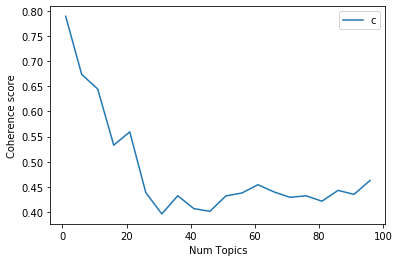

In [0]:
limit=100; start=1; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [0]:
Tensor = torch.FloatTensor
import torch.autograd as autograd

class Generator(nn.Module):
    def __init__(self, opt):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(opt['num_topics'], opt['enc_mid_layer']),
            nn.LeakyReLU(),
            # nn.LayerNorm(opt['enc_mid_layer']),
            nn.Linear(opt['enc_mid_layer'], opt['vocab_size']),
            nn.Softmax(-1)
        )

    def forward(self, z):
        z = self.model(z)
        return z


class Discriminator(nn.Module):
    def __init__(self, opt):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(opt['vocab_size'], opt['dec_mid_layer']),
            nn.LeakyReLU(),
            nn.Linear(opt['dec_mid_layer'], 1)
        )

    def forward(self, z):
        z = self.model(z)
        return z


def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1))).to(device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True).to(device)
    # print(interpolates.shape)
    d_interpolates = D(interpolates)
    # print(d_interpolates.shape)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False).to(device)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight)

# ----------
#  Training
# ----------
def trainer(dataloader, opt, generator, discriminator, optimizer_G, optimizer_D):
    for epoch in range(opt['n_epochs']):
        for i, real_data in enumerate(dataloader):

            # Configure input
            real_data = real_data.float().to(device)

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            dirichlet = torch.distributions.dirichlet.Dirichlet(torch.tensor([1/opt['num_topics'] for _ in range(opt['num_topics'])]))
            sample = dirichlet.sample()

            # Sample noise as generator input
            z = Variable(sample.repeat(real_data.shape[0],1)).to(device)

            # Generate a batch of images
            fake_data = generator(z)

            # Real images
            real_validity = discriminator(real_data)
            # Fake fake_data
            fake_validity = discriminator(fake_data)
            # Gradient penalty
            gradient_penalty = compute_gradient_penalty(discriminator, real_data.data, fake_data.data)
            # Adversarial loss
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + opt['lambda_gp'] * gradient_penalty
            wasserstein_d = -torch.mean(real_validity) + torch.mean(fake_validity)
            d_loss.backward()
            optimizer_D.step()

            optimizer_G.zero_grad()

            # Train the generator every n_critic steps
            if i % opt['n_critic'] == 0:

                # -----------------
                #  Train Generator
                # -----------------

                # Generate a batch of images
                fake_data = generator(z)
                # Loss measures generator's ability to fool the discriminator
                # Train on fake images
                fake_validity = discriminator(fake_data)
                g_loss = -torch.mean(fake_validity)

                g_loss.backward()
                optimizer_G.step()

                print(
                    "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [Wasserstein Distance: %f]"
                    % (epoch, opt['n_epochs'], i, len(dataloader), d_loss.item(), g_loss.item(), wasserstein_d.item())
                )

In [0]:
class TopicModel(Dataset):

    def __init__(self, corpus = corpus_tfidf, len_dict = len(dictionary)):
        self.corpus = corpus
        self.len_dict = len_dict

    def __len__(self):
        return len(self.corpus)

    def __getitem__(self, idx):
        sample = np.zeros(self.len_dict)
        index, value = zip(*self.corpus[idx])
        sample[list(index)] = list(value)
        sample = sample/sample.sum()
        return sample

In [0]:
args = {'num_topics': 5,'enc_mid_layer': 100, 'dec_mid_layer': 100, 'lambda_gp':10, 'vocab_size': len(dictionary), 'batch_size': 128, 'n_epochs': 50, 'n_critic': 5}

dataset = TopicModel()
loader = torch.utils.data.DataLoader(dataset = dataset, 
                                      batch_size = args['batch_size'],
                                      shuffle = True)

def compute_coherence_ATM(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = pickle.load(open('/content/drive/My Drive/Topic_Modeling/GAN_Coherence.pkl','rb'))
    model_list = []
    best_coherence = 0
    i = 0
    for num_topics in range(start, limit, step):
        i = i + 1
        if i <= len(coherence_values):
            continue
        args['num_topics'] = num_topics
        # Loss weight for gradient penalty
        lambda_gp = 10

        # Initialize generator and discriminator
        generator = Generator(args).to(device)
        discriminator = Discriminator(args).to(device)
        generator.apply(init_weights)
        discriminator.apply(init_weights)
        # Optimizers
        optimizer_G = torch.optim.Adam(generator.parameters(), lr = 0.0001, betas=(0, 0.9))
        optimizer_D = torch.optim.Adam(discriminator.parameters(), lr = 0.0001, betas=(0, 0.9))

        trainer(loader, args, generator, discriminator, optimizer_G, optimizer_D)
        emb = [generator(Tensor([[0 if i != j else 1 for j in range(args['num_topics'])]]).to(device)).squeeze() for i in range(args['num_topics'])]
        feature_names = list(zip(*sorted(dictionary.items(), key=lambda x:x[0])))[1]

        topics = [[feature_names[j] for j in emb[i].argsort(descending=True)[:n_top_words - 1]] for i in range(len(emb))]
        coherencemodel = CoherenceModel(topics = topics, texts = texts, dictionary = dictionary, coherence = 'c_v', topn = n_top_words)
        coherence_values.append(coherencemodel.get_coherence())
        pickle.dump(coherence_values, open('/content/drive/My Drive/Topic_Modeling/GAN_Coherence.pkl','wb'))
        if coherence_values[-1] > best_coherence:
            best_coherence = coherence_values[-1]
            best_disc_model = copy.deepcopy(discriminator.state_dict())
            best_enc_model = copy.deepcopy(generator.state_dict())
            best_model = [best_enc_model, best_disc_model]
    return best_model, coherence_values



In [0]:
best_model, coherence_values = compute_coherence_ATM(dictionary=dictionary, corpus=corpus_tfidf, texts=df['tokenized_desc_title'], start=1, limit=100, step=5)

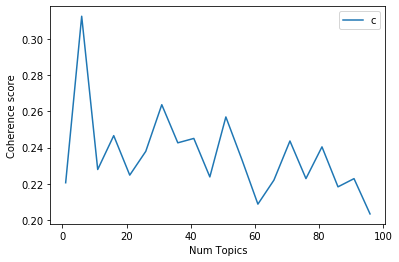

In [10]:
import matplotlib.pyplot as plt
limit=100; start=1; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pickle
coherence_values = pickle.load(open('/content/drive/My Drive/Topic_Modeling/GAN_Coherence.pkl','rb'))

In [9]:
len(coherence_values)

20

1
